In [10]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [11]:
def solution(x,t,L,n_max):
    V = t/L + L/3
    for n in range(1,n_max+1):
        V+=-2*L/(math.pi**2*n**2)*torch.exp(-math.pi**2*n**2*t/L**2)*torch.cos(math.pi*n*x/L)
    return -2 + 2*torch.sqrt(-x + x**2/(2*L) + 1 + V)

In [12]:
L = 3.0  # длина стержня
T = 1.0 

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)



In [13]:
def pc(u):
    return torch.full_like(u,1) + 0.5*u
def K_(u):
    return torch.full_like(u,1) + 0.5*u
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)  # производная по времени
    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # вторая производная по x
    K = K_(u)
    du_x = dde.grad.jacobian(u,x,i=0,j=0)
    dK_u = dde.grad.jacobian(K,u, i = 0, j = 0)
    
    return du_t - (K * du_xx + dK_u*(du_x)**2)/pc(u)
def pde(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    numerator = u_xx * (1 + u/2) + (u_x * u_x) / 2
    return u_t - numerator / (1 + u/2)
def boundary_left(x, on_boundary):
    
    return on_boundary and np.isclose(x[0], 0) and not np.isclose(x[1],0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and not np.isclose(x[1],0)

def boundary_left_0(x, on_boundary):
    
    return on_boundary and np.isclose(x[0], 0) and np.isclose(x[1],0)
def boundary_right_0(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and np.isclose(x[1],0)

def right_condition(x, u, _):
    grad = dde.grad.jacobian(u, x, i = 0, j = 0)

    return -K_(u)*grad 
def left_condition(x,u,_):
    grad = dde.grad.jacobian(u, x, i = 0, j = 0)

    return -K_(u)*grad - 1
bc_right = dde.OperatorBC(geomtime, right_condition, boundary_right)
bc_left = dde.OperatorBC(geomtime, left_condition, boundary_left)

ic = dde.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_left, bc_right,ic],
    num_domain=2000,  # точек внутри области
    num_boundary=200, # точек на границе
    num_initial=200,  # точек для начального условия
    
)
net = dde.nn.FNN(
    [2] + [100] * 2 + [1],  # 2 входа (x,t), 4 слоя по 32 нейрона, 1 выход
    "tanh",
    "Glorot normal",
)
# Модель и обучение
model = dde.Model(data, net)



In [14]:
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

model.compile("adam", lr=1e-4, loss=torch.nn.MSELoss(reduction='sum'), loss_weights=[1,1,1,100])
model.train(iterations=8000,callbacks=[resampler])
model.compile('L-BFGS', loss = torch.nn.MSELoss(reduction='sum'), loss_weights= [1,1,1,100])
losshistory, train_state = model.train()


Compiling model...
'compile' took 0.012241 s



Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.29e+02, 7.64e+01, 1.88e+00, 1.10e+03]    [2.29e+02, 7.64e+01, 1.88e+00, 1.10e+03]    []  
1000      [2.52e-01, 9.37e+01, 2.23e-02, 1.22e+00]    [2.58e-01, 9.37e+01, 2.23e-02, 1.22e+00]    []  
2000      [9.99e-01, 7.76e+01, 1.03e-01, 5.86e+00]    [1.02e+00, 7.76e+01, 1.03e-01, 5.86e+00]    []  
3000      [7.86e+00, 3.27e+01, 2.64e-02, 7.25e+00]    [8.13e+00, 3.27e+01, 2.64e-02, 7.25e+00]    []  
4000      [2.04e+00, 9.67e+00, 2.87e-01, 4.46e+00]    [2.08e+00, 9.67e+00, 2.87e-01, 4.46e+00]    []  
5000      [1.53e+00, 7.40e+00, 9.63e-02, 3.34e+00]    [1.51e+00, 7.40e+00, 9.63e-02, 3.34e+00]    []  
6000      [1.52e+00, 5.30e+00, 5.84e-03, 2.31e+00]    [1.51e+00, 5.30e+00, 5.84e-03, 2.31e+00]    []  
7000      [1.41e+00, 3.62e+00, 2.36e-02, 1.72e+00]    [1.42e+00, 3.62e+00, 2.36e-02, 1.72e+00]    []  
8000      [1.20e+00, 3.13e+00, 3.36e-02, 1.46e+

Saving loss history to /home/ivan/MEPHI/nauchka/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/test.dat ...


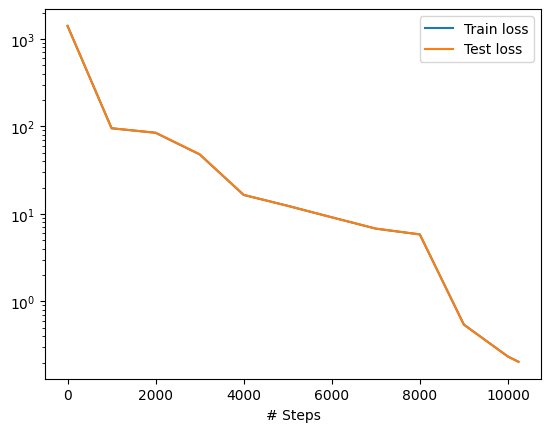

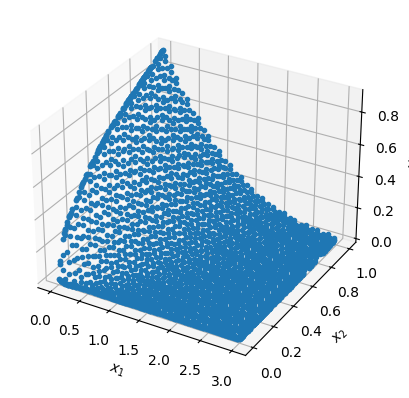

tensor([-0.6982])


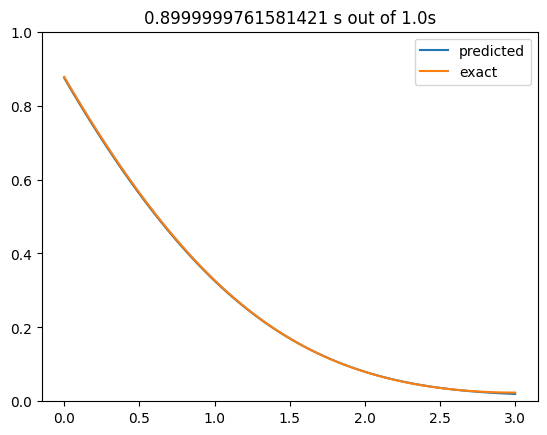

In [16]:
# Визуализация
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
u = []
u_exact = []
t_check = torch.Tensor([0.9])
for x in np.linspace(0,L,100):
    u.append(model.predict(torch.Tensor([x,t_check])))
    
    u_exact.append(solution(torch.Tensor([x]),t_check,L,200))
print((u_exact[1] - u_exact[0])*100/L)
plt.plot(np.linspace(0,L,100), u, label = 'predicted')
plt.plot(np.linspace(0,L,100), u_exact, label = 'exact')
plt.title(f'{t_check.item()} s out of {T}s')
plt.ylim(0,1)
plt.savefig('plot1.png')
plt.legend()